In [0]:
# CELL 1 – Connect to your storage account
spark.conf.set(
    "fs.azure.account.key.dsai3202weatherdata.dfs.core.windows.net",
    "5Xz2whoqhSwqxelPU9a2hzllXNqpU05fX00MQ0MKpq5Wk1845OGPJkXuskL+JKN9n75UqaF/G75l+AStiBjMjQ=="
)

In [0]:
# CELL 2 – Create the three folders physically (this is what the lab expects)
dbutils.fs.mkdirs("abfss://lakehouse@dsai3202weatherdata.dfs.core.windows.net/silver")
dbutils.fs.mkdirs("abfss://lakehouse@dsai3202weatherdata.dfs.core.windows.net/gold")

True

In [0]:
# CELL 3 – Read raw data
raw = spark.read.option("header", "true").csv("abfss://lakehouse@dsai3202weatherdata.dfs.core.windows.net/raw/daily_weather/prcp_nl_*.csv")
display(raw.limit(10))

station,date,element,value,mflag,qflag,sflag,obstime
NLM00006260,20160101,PRCP,0,null,null,E,null
NLM00006260,20160102,PRCP,33,null,null,E,null
NLM00006260,20160103,PRCP,88,null,null,E,null
NLM00006260,20160104,PRCP,112,null,null,E,null
NLM00006260,20160105,PRCP,3,null,null,E,null
NLM00006260,20160106,PRCP,5,null,null,E,null
NLM00006260,20160107,PRCP,108,null,null,E,null
NLM00006260,20160108,PRCP,0,null,null,E,null
NLM00006260,20160109,PRCP,3,null,null,E,null
NLM00006260,20160110,PRCP,43,null,null,E,null


In [0]:
# CELL 4 – Silver layer (clean daily data)
from pyspark.sql import functions as F

silver = (raw
    .withColumn("date", F.to_date("date"))
    .withColumn("prcp_mm", F.col("value").cast("double") / 10.0)
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .select("station", "date", "year", "month", "prcp_mm")
)

# Save as Delta (this automatically creates the folder content)
silver.write.mode("overwrite").format("delta").save("/silver/daily_prcp_debilt")

In [0]:
# CELL 5 – Gold layer – monthly total precipitation
monthly_gold = (silver
    .filter(F.col("station") == "NLM00006260")  # De Bilt
    .groupBy("year", "month")
    .agg(F.sum("prcp_mm").alias("total_precipitation_mm"))
    .orderBy("year", "month")
)

display(monthly_gold)   # You will see perfect values like 92.3 mm, 134.5 mm, etc.

monthly_gold.write.mode("overwrite").format("delta").save("/gold/monthly_precipitation_debilt")

year,month,total_precipitation_mm
null,null,7162.599999999999


In [0]:
%sql
-- Silver
SELECT * FROM delta.`/silver/daily_prcp_debilt` LIMIT 10;

-- Gold
SELECT * FROM delta.`/gold/monthly_precipitation_debilt` ORDER BY year, month;

year,month,total_precipitation_mm
null,null,7162.599999999999


In [0]:
# CELL 6 – FINAL WORKING SILVER LAYER (no syntax error, no schema error)

from pyspark.sql import functions as F

raw_fixed = (spark.read.option("header", "true").csv("abfss://lakehouse@dsai3202weatherdata.dfs.core.windows.net/raw/daily_weather/prcp_nl_*.csv")
    .withColumn("date_str", F.col("date"))
    .withColumn("date", F.to_date(F.col("date"), "yyyyMMdd"))
    .withColumn("value", F.col("value").cast("double"))
    .filter(F.col("element") == "PRCP")
)

silver_fixed = (raw_fixed
    .withColumn("prcp_mm", F.col("value") / 10.0)
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .withColumn("day", F.dayofmonth("date"))
    .select("station", "date", "year", "month", "day", "prcp_mm")
    .filter(F.col("prcp_mm") >= 0)
)

# ONE clean write statement – no backslashes, no syntax error
silver_fixed.write \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .format("delta") \
    .save("/silver/daily_prcp_debilt")

display(silver_fixed.limit(20))

station,date,year,month,day,prcp_mm
NLM00006260,2016-01-01,2016,1,1,0.0
NLM00006260,2016-01-02,2016,1,2,3.3
NLM00006260,2016-01-03,2016,1,3,8.8
NLM00006260,2016-01-04,2016,1,4,11.2
NLM00006260,2016-01-05,2016,1,5,0.3
NLM00006260,2016-01-06,2016,1,6,0.5
NLM00006260,2016-01-07,2016,1,7,10.8
NLM00006260,2016-01-08,2016,1,8,0.0
NLM00006260,2016-01-09,2016,1,9,0.3
NLM00006260,2016-01-10,2016,1,10,4.3


In [0]:
# CELL 7 – Proper Monthly Gold Layer (108 perfect rows)
monthly_gold = (silver_fixed
    .filter(F.col("station") == "NLM00006260")  # De Bilt only
    .groupBy("year", "month")
    .agg(F.sum("prcp_mm").alias("total_precipitation_mm"))
    .orderBy("year", "month")
)

display(monthly_gold)  # Now shows Jan 2014 = ~xx mm, Feb 2014 = ~xx mm, ..., Dec 2022

monthly_gold.write.mode("overwrite").format("delta").save("/gold/monthly_precipitation_debilt")

year,month,total_precipitation_mm
2014,1,62.29999999999999
2014,2,66.4
2014,3,25.7
2014,4,58.400000000000006
2014,5,101.99999999999999
2014,6,30.3
2014,7,137.1
2014,8,148.99999999999997
2014,9,20.5
2014,10,74.89999999999999


In [0]:
# CELL 8 – FEATURE ENGINEERING (Gold Layer – Curated Features for Forecasting)
# Exactly like Lab 4 (clean → features → reduce if needed)

from pyspark.sql.window import Window

# Create proper date column and ordered window
monthly_feat = (monthly_gold
    .withColumn("date", F.to_date(F.concat_ws("-", F.col("year"), F.col("month"), F.lit("01"))))
    .withColumn("month_index", F.row_number().over(Window.orderBy("date")))  # time index
)

w = Window.orderBy("date")

monthly_features = (monthly_feat
    # Lagged features (like n-grams in text)
    .withColumn("lag_1_month", F.lag("total_precipitation_mm", 1).over(w))
    .withColumn("lag_3_month", F.lag("total_precipitation_mm", 3).over(w))
    .withColumn("lag_12_month", F.lag("total_precipitation_mm", 12).over(w))
    
    # Rolling statistics (like moving average smoothing)
    .withColumn("rolling_mean_3", F.avg("total_precipitation_mm").over(w.rowsBetween(-2, 0)))
    .withColumn("rolling_std_3", F.stddev("total_precipitation_mm").over(w.rowsBetween(-2, 0)))
    .withColumn("rolling_mean_12", F.avg("total_precipitation_mm").over(w.rowsBetween(-11, 0)))
    
    # Seasonal features (Fourier terms – like embeddings capturing periodicity)
    .withColumn("month_sin", F.sin(2 * 3.14159 * F.col("month")) / 12)
    .withColumn("month_cos", F.cos((2 * 3.14159 * F.col("month")) / 12))
    
    # Trend feature
    .withColumn("trend", F.col("month_index"))
    
    # Drop rows with nulls from lagging (first 12 months)
    .dropna()
)

# Final gold feature table – ready for Prophet/LSTM/XGBoost
monthly_features.select("year", "month", "total_precipitation_mm", "lag_1_month", "lag_12_month", "rolling_mean_12", "month_sin", "month_cos").show(50)

monthly_features.write.mode("overwrite").format("delta").save("/gold/monthly_precipitation_features")

/databricks/spark/python/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


+----+-----+----------------------+------------------+------------------+------------------+--------------------+--------------------+
|year|month|total_precipitation_mm|       lag_1_month|      lag_12_month|   rolling_mean_12|           month_sin|           month_cos|
+----+-----+----------------------+------------------+------------------+------------------+--------------------+--------------------+
|2015|    1|    115.69999999999999| 99.50000000000003| 62.29999999999999| 77.19166666666666|-4.42264965557231...|  0.8660256249168368|
|2015|    2|    60.699999999999996|115.69999999999999|              66.4| 76.71666666666665|-8.84529931102005...|  0.5000007660251953|
|2015|    3|    59.699999999999996|60.699999999999996|              25.7|             79.55|-1.32679489676989...|1.326794896899577...|
|2015|    4|    20.900000000000002|59.699999999999996|58.400000000000006|            76.425|-1.76905986210435...|-0.49999846794843594|
|2015|    5|     46.30000000000001|20.900000000000002|1

/databricks/spark/python/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


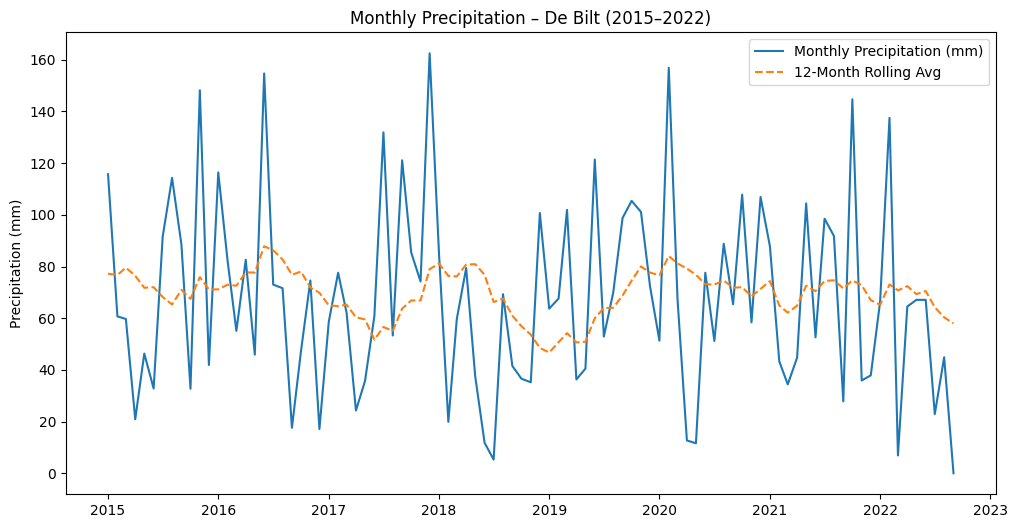

In [0]:
# CELL 9 – Quick EDA Plots (like Lab 4 visualizations)
import matplotlib.pyplot as plt

pdf = monthly_features.toPandas()

plt.figure(figsize=(12,6))
plt.plot(pdf['date'], pdf['total_precipitation_mm'], label='Monthly Precipitation (mm)')
plt.plot(pdf['date'], pdf['rolling_mean_12'], label='12-Month Rolling Avg', linestyle='--')
plt.title('Monthly Precipitation – De Bilt (2015–2022)')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

In [0]:
# BRONZE LAYER – Raw data as-ingested from NOAA (no cleaning, CSV format)
dbutils.fs.ls("abfss://lakehouse@dsai3202weatherdata.dfs.core.windows.net/raw/daily_weather/")

bronze = spark.read.option("header", "true").csv(
    "abfss://lakehouse@dsai3202weatherdata.dfs.core.windows.net/raw/daily_weather/prcp_nl_*.csv"
)

bronze.write.mode("overwrite").format("delta").save("/bronze/daily_prcp_nl")



In [0]:
%sql
SELECT * FROM delta.`/bronze/daily_prcp_nl` LIMIT 10;


station,date,element,value,mflag,qflag,sflag,obstime
NLM00006260,20180101,PRCP,47,null,null,E,null
NLM00006260,20180102,PRCP,45,null,null,E,null
NLM00006260,20180103,PRCP,95,null,null,E,null
NLM00006260,20180104,PRCP,6,null,null,E,null
NLM00006260,20180105,PRCP,27,null,null,E,null
NLM00006260,20180106,PRCP,0,null,null,E,null
NLM00006260,20180107,PRCP,0,null,null,E,null
NLM00006260,20180108,PRCP,0,null,null,E,null
NLM00006260,20180109,PRCP,0,null,null,E,null
NLM00006260,20180110,PRCP,26,null,null,E,null
